In [1]:
# Importar todas las librerías necesarias.
import csv
import pandas as pd
import datetime
import os
import numpy as np
import random
import math
import matplotlib.pyplot as plt

from htm.bindings.sdr import SDR, Metrics
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.encoders.date import DateEncoder
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood
from htm.bindings.algorithms import Predictor

In [2]:
# Default parameters in HTM
default_parameters = {
# there are 2 (3) encoders: "value" (RDSE) & "time" (DateTime weekend, timeOfDay)
 'enc': {
      "value" :
         {'resolution': 0.88, 'size': 700, 'sparsity': 0.02},
      "time": 
         {'timeOfDay': (30, 1)} #, 'weekend': 21}
 },
 'predictor': {'sdrc_alpha': 0.1},
 'sp': {'boostStrength': 3.0,
        'columnCount': 1638,
        'localAreaDensity': 0.04395604395604396,
        'potentialPct': 0.85,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'synPermInactiveDec': 0.006},
 'tm': {'activationThreshold': 17,
        'cellsPerColumn': 13,
        'initialPerm': 0.21,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'minThreshold': 10,
        'newSynapseCount': 32,
        'permanenceDec': 0.1,
        'permanenceInc': 0.1},
 'anomaly': {
   'likelihood': 
       {'probationaryPct': 0.1,
        'reestimationPeriod': 100}
 }
}

In [3]:
# Read the data file
data = pd.read_excel('../docs/files/DL_Traffic_202006.xlsx', index_col=0)
float(data.iloc[0])

13800.265

In [4]:
# Make the encoder
dateEncoder = DateEncoder(timeOfDay= default_parameters["enc"]["time"]["timeOfDay"])
scalarEncoderParams             = RDSE_Parameters()
scalarEncoderParams.size        = default_parameters["enc"]["value"]["size"]
scalarEncoderParams.sparsity    = default_parameters["enc"]["value"]["sparsity"]
scalarEncoderParams.resolution  = default_parameters["enc"]["value"]["resolution"]
scalarEncoder = RDSE( scalarEncoderParams )
encodingWidth = (dateEncoder.size + scalarEncoder.size)
enc_info = Metrics( [encodingWidth], 999999999)

In [5]:
# Make the HTM
spParams = default_parameters["sp"]
sp = SpatialPooler(
    inputDimensions            = (encodingWidth,),
    columnDimensions           = (spParams["columnCount"],),
    potentialPct               = spParams["potentialPct"],
    potentialRadius            = encodingWidth,
    globalInhibition           = True,
    localAreaDensity           = spParams["localAreaDensity"],
    synPermInactiveDec         = spParams["synPermInactiveDec"],
    synPermActiveInc           = spParams["synPermActiveInc"],
    synPermConnected           = spParams["synPermConnected"],
    boostStrength              = spParams["boostStrength"],
    wrapAround                 = True
)
sp_info = Metrics( sp.getColumnDimensions(), 999999999 )

# Temporal Memory Parameters
tmParams = default_parameters["tm"]
tm = TemporalMemory(
    columnDimensions          = (spParams["columnCount"],),
    cellsPerColumn            = tmParams["cellsPerColumn"],
    activationThreshold       = tmParams["activationThreshold"],
    initialPermanence         = tmParams["initialPerm"],
    connectedPermanence       = spParams["synPermConnected"],
    minThreshold              = tmParams["minThreshold"],
    maxNewSynapseCount        = tmParams["newSynapseCount"],
    permanenceIncrement       = tmParams["permanenceInc"],
    permanenceDecrement       = tmParams["permanenceDec"],
    predictedSegmentDecrement = 0.0,
    maxSegmentsPerCell        = tmParams["maxSegmentsPerCell"],
    maxSynapsesPerSegment     = tmParams["maxSynapsesPerSegment"]
)
tm_info = Metrics( [tm.numberOfCells()], 999999999 )

In [6]:
# Setup Likelihood
anParams           = default_parameters["anomaly"]["likelihood"]
probationaryPeriod = int(math.floor(float(anParams["probationaryPct"])*len(data)))
learningPeriod     = int(math.floor(probationaryPeriod / 2.0))
anomaly_history    = AnomalyLikelihood(learningPeriod= learningPeriod,
                                    estimationSamples= probationaryPeriod - learningPeriod,
                                    reestimationPeriod= anParams["reestimationPeriod"])

predictor = Predictor( steps=[1, 5], alpha=default_parameters["predictor"]['sdrc_alpha'] )
predictor_resolution = 1

In [7]:
# Iterate through every datum in dataset
inputs      = []
anomaly     = []
anomalyProb = []
predictions = {1: [], 5: []}
for count in range(len(data)):

    # Convert date string into Python date object. # 2020-06-01 00:15:00
    dateString = datetime.datetime.strptime(str(data.index[count]), "%Y-%m-%d %H:%M:%S")

    # Convert data value string into float.
    consumption = float(data.iloc[count])/1024
    inputs.append( consumption )

    # Call the encoders to create bit representations for each value.  These are SDR objects.
    dateBits        = dateEncoder.encode(dateString)
    consumptionBits = scalarEncoder.encode(consumption)

    # Concatenate all these encodings into one large encoding for Spatial Pooling.
    encoding = SDR( encodingWidth ).concatenate([consumptionBits, dateBits])
    enc_info.addData( encoding )

    # Create an SDR to represent active columns, This will be populated by the
    # compute method below. It must have the same dimensions as the Spatial Pooler.
    activeColumns = SDR( sp.getColumnDimensions() )

    # Execute Spatial Pooling algorithm over input space.
    sp.compute(encoding, True, activeColumns)
    sp_info.addData( activeColumns )

    # Execute Temporal Memory algorithm over active mini-columns.
    tm.compute(activeColumns, learn=True)
    tm_info.addData( tm.getActiveCells().flatten() )

    # Predict what will happen, and then train the predictor based on what just happened.
    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1, 5):
        if pdf[n]:
            predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
        else:
            predictions[n].append(float('nan'))

    anomalyLikelihood = anomaly_history.anomalyProbability( consumption, tm.anomaly )
    anomaly.append( tm.anomaly )
    anomalyProb.append( float(2*(1-anomalyLikelihood)) )

    predictor.learn(count, tm.getActiveCells(), int(consumption / predictor_resolution))

Predictive Error (RMS) 1 steps ahead: 4.226181226634594
Predictive Error (RMS) 5 steps ahead: 4.5169716775169
Anomaly Mean 0.03543595702536145
Anomaly Std  0.12817115079179103


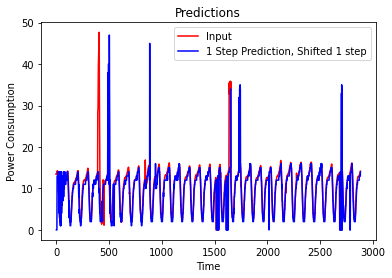

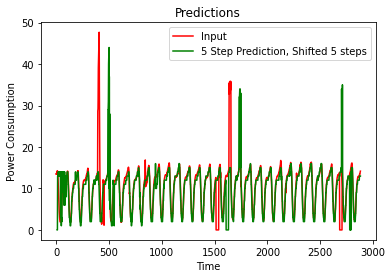

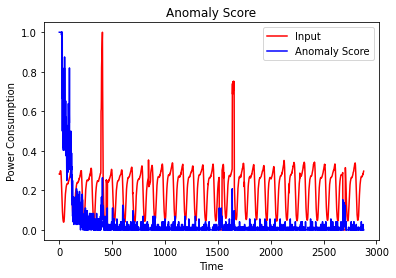

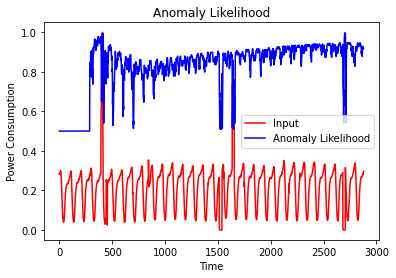

In [8]:
# Print information & Statistics about HTM state.
# print(predictions)
# Shift the predictions so that they are aligned with the input they predict.
for n_steps, pred_list in predictions.items():
    for x in range(n_steps):
        pred_list.insert(0, float('nan'))
        pred_list.pop()

# Calculate the predictive accuracy, Root-Mean-Squared
accuracy         = {1: 0, 5: 0}
accuracy_samples = {1: 0, 5: 0}

for idx, inp in enumerate(inputs):
    for n in predictions: # For each [N]umber of time steps ahead which was predicted.
        val = predictions[n][ idx ]
        if not math.isnan(val):
            accuracy[n] += (inp - val) ** 2
            accuracy_samples[n] += 1
for n in sorted(predictions):
    accuracy[n] = (accuracy[n] / accuracy_samples[n]) ** .5
    print("Predictive Error (RMS)", n, "steps ahead:", accuracy[n])

# Show info about the anomaly (mean & std)
print("Anomaly Mean", np.mean(anomaly))
print("Anomaly Std ", np.std(anomaly))

# Plot the Predictions 1 Step.
# plt.subplot(1,2,1)
plt.title("Predicción - 15 minutos")
plt.xlabel("Instante de Tiempo")
plt.ylabel("DL Bytes (TB)")
plt.plot(np.arange(len(inputs)), inputs, 'red',
            np.arange(len(inputs)), predictions[1], 'blue')
plt.legend(labels=('Input', '1 Step Prediction, Shifted 1 step'))
plt.show()

# Plot the Predictions 5 Steps.
# plt.subplot(1,2,1)
plt.title("Predicción - 1 hora")
plt.xlabel("Instante de Tiempo")
plt.ylabel("DL Bytes (TB)")
plt.plot(np.arange(len(inputs)), inputs, 'red',
            np.arange(len(inputs)), predictions[5], 'green',)
plt.legend(labels=('Input', '1 Step Prediction, Shifted 5 steps'))
plt.show()

# Plot anomaly score
# plt.subplot(1,2,2)
plt.title("Anomaly Score")
plt.xlabel("Instante de Tiempo")
inputs = np.array(inputs) / max(inputs)
plt.plot(np.arange(len(inputs)), inputs, 'red',
            np.arange(len(inputs)), anomaly, 'blue',)
plt.legend(labels=('Input', 'Anomaly Score'))
plt.show()

# Plot anomaly likelihood
# plt.subplot(2,1,2)
plt.title("Anomaly Likelihood")
plt.xlabel("Instante de Tiempo")
inputs = np.array(inputs) / max(inputs)
plt.plot(np.arange(len(inputs)), inputs, 'red',
            np.arange(len(inputs)), anomalyProb, 'blue',)
plt.legend(labels=('Input', 'Anomaly Likelihood'))
plt.show()

# print(accuracy[5])